## 💰 Money Laundering Detection System (ML Project)

---



This project uses **Machine Learning** to detect suspicious or fraudulent financial transactions.  
We preprocess AML data, train an **XGBoost model**, evaluate its performance, and deploy it using **Streamlit + Ngrok** for real-time predictions.

**Steps Covered:**
1. Data loading and preprocessing  
2. Feature selection and model training  
3. Evaluation and feature importance  
4. Model saving and web app deployment


## Install Required Libraries

---


*italicized text*We install all necessary Python libraries such as Streamlit, Pyngrok, Scikit-learn, and XGBoost for model training and deployment.


In [ ]:
!pip install streamlit pyngrok scikit-learn xgboost --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 64.3 MB/s eta 0:00:00


## 📚 Import Dependencies

---


Import essential libraries for data manipulation, preprocessing, and model training (Pandas, NumPy, Sklearn, XGBoost, etc.).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from pyngrok import ngrok
import streamlit as st
import random
from datetime import datetime, timedelta

## ⚙️ Generate or Preprocess Transaction Data

---


This section defines logic to simulate or preprocess anti-money-laundering (AML) transaction data for model input.


In [ ]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from collections import defaultdict
import math

# -----------------------------
# CONFIGURATION
# -----------------------------
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

num_records = 100_000                # Total transactions to generate
fraud_ratio = 0.05                   # Base random fraud probability
max_gap_minutes = 120                # threshold for "rapid transaction" (in minutes)
num_accounts = 4000                  # size of account pool (increase to diversify)
start_date = datetime(2023, 1, 1)
end_date = datetime(2025, 10, 1)

accounts = [f"A{idx}" for idx in range(1000, 1000 + num_accounts)]
# receiver pool slightly larger to allow many-to-many mappings
receiver_pool = [f"A{idx}" for idx in range(2000, 2000 + (num_accounts * 2))]

countries = ['India', 'USA', 'UK', 'Singapore', 'UAE', 'Germany', 'Nigeria', 'China']
channels = ['Online', 'ATM', 'Bank Transfer', 'Mobile App']
account_types = ['Savings', 'Current', 'Business', 'Offshore']

# -----------------------------
# HELPERS
# -----------------------------
def random_between_dates(start, end):
    """Return random datetime between start and end (uniform)."""
    delta = end - start
    rand_seconds = random.randint(0, int(delta.total_seconds()))
    return start + timedelta(seconds=rand_seconds)

def generate_countries():
    return random.choice(countries), random.choice(countries)

def generate_channel():
    return random.choice(channels)

def generate_account_type():
    return random.choice(account_types)

def minutes_to_timedelta(minutes):
    return timedelta(seconds=int(minutes * 60))

# -----------------------------
# TRANSACTION COUNT DISTRIBUTION ACROSS ACCOUNTS
# -----------------------------
# We'll allocate transactions per account using a Poisson-like distribution so some accounts have many txns,
# most have few, which is realistic.
mean_tx_per_account = num_records / num_accounts  # ~25
# sample counts, then rescale to sum to num_records
raw_counts = np.random.poisson(lam=mean_tx_per_account, size=num_accounts).astype(int)
# Ensure at least 1 transaction per account to avoid zeros (optional)
raw_counts[raw_counts == 0] = 1

# Scale counts to exactly num_records
total_raw = raw_counts.sum()
scaling_factor = num_records / total_raw
scaled = np.floor(raw_counts * scaling_factor).astype(int)

# correct rounding errors to match exactly num_records
diff = num_records - scaled.sum()
idx = 0
while diff > 0:
    scaled[idx % num_accounts] += 1
    idx += 1
    diff -= 1
while diff < 0:
    # remove 1 from accounts with >1
    for j in range(num_accounts):
        if scaled[j] > 1 and diff < 0:
            scaled[j] -= 1
            diff += 1
        if diff == 0:
            break

txn_counts_per_account = dict(zip(accounts, scaled))

# -----------------------------
# GENERATE TRANSACTIONS PER ACCOUNT (chronological)
# -----------------------------
rows = []
transaction_counter = 0

for account_id, count in txn_counts_per_account.items():
    # pick a random start time for this account somewhere between start_date and end_date - 1 day
    account_start = random_between_dates(start_date, end_date - timedelta(days=1))
    last_time = account_start
    last_receiver_country = None
    # Simulate inter-arrival times (minutes) using a mixture: many short gaps, some long gaps
    # We'll draw from exponential (for short bursts) plus occasional long gaps
    for n in range(count):
        transaction_counter += 1
        transaction_id = f"T{transaction_counter:07d}"  # zero-padded

        # Interarrival minutes
        if n == 0:
            # first transaction time is last_time (already set)
            txn_time = last_time
        else:
            # with 80% chance use short exponential gap (burst), else a longer gap
            if random.random() < 0.8:
                gap_minutes = np.random.exponential(scale=60)  # avg 60 min
            else:
                gap_minutes = np.random.exponential(scale=60*24)  # long gap avg 1 day
            # clamp gap so we don't jump too far beyond end_date, and make it at least 1 minute
            gap_minutes = max(1, min(gap_minutes, (end_date - last_time).total_seconds() / 60 - 1))
            txn_time = last_time + minutes_to_timedelta(gap_minutes)

        # If txn_time goes beyond end_date, wrap back into allowed range (rare)
        if txn_time > end_date:
            txn_time = random_between_dates(start_date, end_date)

        # Receiver and party details
        receiver_id = random.choice(receiver_pool)
        amount = round(random.uniform(100, 1_000_000), 2)
        sender_country, receiver_country = generate_countries()
        channel = generate_channel()
        account_type = generate_account_type()
        is_weekend = 1 if txn_time.weekday() >= 5 else 0
        high_value = 1 if amount > 500_000 else 0
        international = 1 if sender_country != receiver_country else 0

        # previous transaction info for this account
        if last_time:
            previous_transaction_time = last_time
            time_diff_minutes = (txn_time - last_time).total_seconds() / 60.0
            previous_receiver_country = last_receiver_country
            country_changed = 1 if (previous_receiver_country is not None and previous_receiver_country != receiver_country) else 0
            same_account_multiple_txn = 1 if time_diff_minutes <= max_gap_minutes else 0
        else:
            previous_transaction_time = None
            time_diff_minutes = None
            previous_receiver_country = None
            country_changed = 0
            same_account_multiple_txn = 0

        # FRAUD LOGIC: combine rules + randomness
        fraud = 0
        # Rule 1: High-value international from offshore
        if high_value and international and account_type == 'Offshore':
            fraud = 1
        # Rule 2: Rapid multi-country transfers
        elif same_account_multiple_txn and country_changed and time_diff_minutes is not None and time_diff_minutes <= max_gap_minutes:
            # add randomness to not flag ALL such cases; real systems use scores
            if random.random() < 0.95:
                fraud = 1
        # Rule 3: Weekend unusual high value
        elif is_weekend and high_value and random.random() < 0.25:
            fraud = 1
        # Rule 4: repeated similar amounts to many destinations in short time (smurfing)
        elif same_account_multiple_txn and high_value and random.random() < 0.4:
            fraud = 1
        # Base random fraud
        elif random.random() < fraud_ratio:
            fraud = 1

        rows.append({
            'transaction_id': transaction_id,
            'account_id': account_id,
            'receiver_id': receiver_id,
            'amount': amount,
            'sender_country': sender_country,
            'receiver_country': receiver_country,
            'channel': channel,
            'account_type': account_type,
            'transaction_time': txn_time.strftime("%Y-%m-%d %H:%M:%S"),
            'is_weekend': is_weekend,
            'high_value': high_value,
            'international': international,
            'previous_transaction_time': previous_transaction_time.strftime("%Y-%m-%d %H:%M:%S") if previous_transaction_time else None,
            'time_diff_minutes': round(time_diff_minutes, 2) if time_diff_minutes is not None else None,
            'previous_receiver_country': previous_receiver_country if previous_receiver_country else None,
            'country_changed': country_changed,
            'same_account_multiple_txn': same_account_multiple_txn,
            'is_fraud': fraud
        })

        # update last_time / last_receiver_country for this account
        last_time = txn_time
        last_receiver_country = receiver_country

# -----------------------------
# CREATE DATAFRAME & SAVE CSV
# -----------------------------
df = pd.DataFrame(rows)

# Shuffle dataset globally so records are not sorted by account
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# Save to CSV
output_filename = 'aml_transactions_full_100k.csv'
df.to_csv(output_filename, index=False)

# -----------------------------
# QUICK SUMMARY STATISTICS
# -----------------------------
fraud_counts = df['is_fraud'].value_counts()
fraud_pct = df['is_fraud'].value_counts(normalize=True) * 100

print("✅ Dataset generated and saved to:", output_filename)
print("\n-- Basic counts --")
print(fraud_counts)
print("\n-- Percentages --")
print(fraud_pct.round(3))

# Example head
print("\n-- Sample rows --")
print(df.head(8).to_string(index=False))

✅ Dataset generated and saved to: aml_transactions_full_100k.csv

-- Basic counts --
is_fraud
1    66190
0    33810
Name: count, dtype: int64

-- Percentages --
is_fraud
1    66.19
0    33.81
Name: proportion, dtype: float64

-- Sample rows --
transaction_id account_id receiver_id    amount sender_country receiver_country       channel account_type    transaction_time  is_weekend  high_value  international previous_transaction_time  time_diff_minutes previous_receiver_country  country_changed  same_account_multiple_txn  is_fraud
      T0075722      A4029       A6866 260858.64          India        Singapore Bank Transfer      Current 2024-08-04 16:37:51           1           0              1       2024-08-04 16:14:40              23.18                   Germany                1                          1         1
      T0080185      A4210       A8211 103492.63      Singapore        Singapore        Online      Savings 2024-03-18 15:30:05           0           0              0       20

## 🧹 Data Cleaning

---


Load the AML transaction dataset, handle missing values, and display the shape of the data to verify successful loading.


In [ ]:
df = pd.read_csv("aml_transactions_full_100k.csv")
df['previous_receiver_country'].fillna('Unknown', inplace=True)
print("✅ Dataset loaded. Shape:", df.shape)
df.head()

/tmp/ipython-input-2016814715.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['previous_receiver_country'].fillna('Unknown', inplace=True)


✅ Dataset loaded. Shape: (100000, 18)


,transaction_id,account_id,receiver_id,amount,sender_country,receiver_country,channel,account_type,transaction_time,is_weekend,high_value,international,previous_transaction_time,time_diff_minutes,previous_receiver_country,country_changed,same_account_multiple_txn,is_fraud
0,T0075722,A4029,A6866,260858.64,India,Singapore,Bank Transfer,Current,2024-08-04 16:37:51,1,0,1,2024-08-04 16:14:40,23.18,Germany,1,1,1
1,T0080185,A4210,A8211,103492.63,Singapore,Singapore,Online,Savings,2024-03-18 15:30:05,0,0,0,2024-03-18 14:19:01,71.07,Nigeria,1,1,1
2,T0019865,A1792,A9160,272212.01,UK,China,Mobile App,Savings,2024-11-28 23:24:01,0,0,1,2024-11-28 22:32:19,51.70,USA,1,1,1
3,T0076700,A4068,A4543,14355.62,India,China,Mobile App,Savings,2023-07-30 17:29:14,1,0,1,2023-07-30 15:32:44,116.50,USA,1,1,1
4,T0092992,A4720,A9574,518332.04,Singapore,UK,ATM,Business,2024-10-22 13:19:34,0,1,1,2024-10-22 11:04:07,135.45,India,1,0,0


## 🔎 Feature Selection and Data Preparation

---


Drop irrelevant columns (IDs, timestamps, etc.) and prepare features (`X`) and labels (`y`) for training.


In [ ]:
cols_to_drop = ['transaction_id', 'account_id', 'receiver_id', 'transaction_time', 'previous_transaction_time']
X = df.drop(columns=cols_to_drop + ['is_fraud'])
y = df['is_fraud']

cat_cols = ['sender_country', 'receiver_country', 'channel', 'account_type', 'previous_receiver_country']
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

print("✅ Features ready")

✅ Features ready


## ✂️ Train-Test Split

---


Split the dataset into training and testing subsets (80-20 ratio) to evaluate model performance fairly.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("✅ Train/Test split done")

✅ Train/Test split done


## 🤖 Train the XGBoost Model

---


Train an XGBoost classifier to detect potentially fraudulent (money-laundering) transactions using optimized parameters.


In [ ]:
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=10,
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
print("✅ XGBoost trained successfully")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:27:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost trained successfully


## 📈 Evaluate Model Performance

---


Make predictions and generate a classification report showing accuracy, precision, recall, and F1-score.


📊 Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      6762
           1       0.94      0.94      0.94     13238

    accuracy                           0.93     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.93      0.93      0.93     20000

🎯 ROC-AUC Score: 0.9501879320012983


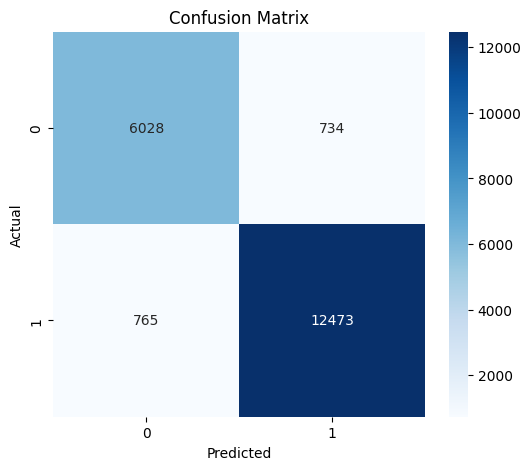

In [ ]:
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:,1]

print("📊 Classification Report:\n", classification_report(y_test, y_pred))
print("🎯 ROC-AUC Score:", roc_auc_score(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 💡 Analyze Feature Importance

---


Display feature importance to understand which transaction features contribute most to detecting money laundering.


,Feature,Importance
11,same_account_multiple_txn,0.741474
10,country_changed,0.126660
6,high_value,0.107323
7,international,0.010068
4,account_type,0.005540
5,is_weekend,0.002052
0,amount,0.001287
9,previous_receiver_country,0.001167
8,time_diff_minutes,0.001152
2,receiver_country,0.001110


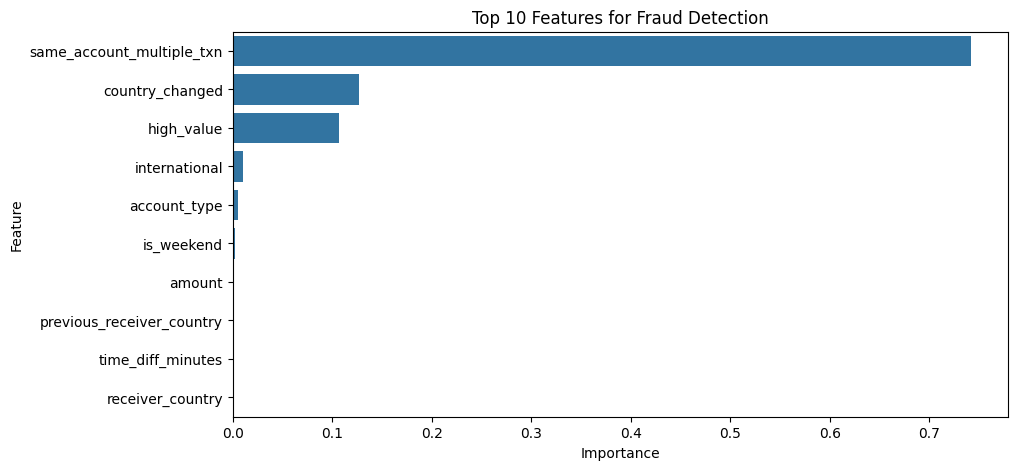

In [ ]:
importance_xgb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

display(importance_xgb.head(10))

plt.figure(figsize=(10,5))
sns.barplot(data=importance_xgb.head(10), x='Importance', y='Feature')
plt.title("Top 10 Features for Fraud Detection")
plt.show()

## 🧠 Retrain or Extend the Model

---


Retrain XGBoost or extend the pipeline for additional experiments or tuning.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Dataset load
df = pd.read_csv("aml_transactions_full_100k.csv")

# Fill missing categorical values
df['previous_receiver_country'].fillna('Unknown', inplace=True)

# Features and target
cols_to_drop = ['transaction_id','account_id','receiver_id','transaction_time','previous_transaction_time']
X = df.drop(columns=cols_to_drop + ['is_fraud'])
y = df['is_fraud']

# Label Encoding for categorical features
cat_cols = ['sender_country','receiver_country','channel','account_type','previous_receiver_country']
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


/tmp/ipython-input-1442677634.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['previous_receiver_country'].fillna('Unknown', inplace=True)


## 💾 Train Final Model

---


Train the final model version with refined parameters for production use.


In [ ]:
# Train model
model = xgb.XGBClassifier(n_estimators=200, max_depth=10, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Test model accuracy
y_pred = model.predict(X_test)
accuracy = (y_pred == y_test).mean()
print(f"✅ Model trained. Test Accuracy: {accuracy:.2f}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:28:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model trained. Test Accuracy: 0.93


## 📦 Save the Trained Model

---


Save the trained XGBoost model using `joblib` for reuse in Streamlit deployment.


In [ ]:
import joblib

# Save trained model
joblib.dump(model, "xgb_model.pkl")
print("✅ Model saved as xgb_model.pkl")

✅ Model saved as xgb_model.pkl


##🌐 Install Streamlit and Pyngrok

---


Install necessary tools for creating and sharing a live web app in Google Colab.


In [ ]:
!pip install streamlit pyngrok --quiet

## 🔑 Set Ngrok Authentication
Authenticate Ngrok using your token to allow tunneling of Streamlit web apps.


In [ ]:
from pyngrok import ngrok

# Set your ngrok auth token
ngrok.set_auth_token("2pZDIIAf2OdOXIWnidHUELiHb0p_7eETgLTrU9gLPr7mZiSRX")

## 🧩 Import Dependencies for Streamlit App

---


Load essential modules and helper functions required by the deployed app.


In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# LabelEncoder
le_sender = LabelEncoder()
le_sender.fit(['India', 'USA', 'UK', 'Singapore', 'UAE', 'Germany', 'Nigeria', 'China'])

# Dummy training data
X_train = pd.DataFrame({
    'amount': [1000, 500000, 75000, 250000, 900000],
    'sender_country': le_sender.transform(['India', 'USA', 'UK', 'Singapore', 'UAE'])
})
y_train = [0,1,0,1,1]  # Example labels

# Random Forest train
rf_model = RandomForestClassifier(n_estimators=200, max_depth=5, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Save model to current directory
joblib.dump(rf_model, "rf_two_feature_model.pkl")
print("✅ Model saved as rf_two_feature_model.pkl")

✅ Model saved as rf_two_feature_model.pkl


## 🖥️ Build Streamlit Application

---


Create a Streamlit UI (`app.py`) that allows users to input transaction data and predict if it’s suspicious.


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder

st.title("💰 AML Fraud Prediction (Manual Input)")

# Load trained model
model = joblib.load("xgb_model.pkl")

# User Input Form
amount = st.number_input("Transaction Amount", min_value=1.0, max_value=1000000.0, value=1000.0)
sender_country = st.selectbox("Sender Country", ['India','USA','UK','Singapore','UAE','Germany','Nigeria','China'])
receiver_country = st.selectbox("Receiver Country", ['India','USA','UK','Singapore','UAE','Germany','Nigeria','China'])
channel = st.selectbox("Transaction Channel", ['Online', 'ATM', 'Bank Transfer', 'Mobile App'])
account_type = st.selectbox("Account Type", ['Savings','Current','Business','Offshore'])
previous_receiver_country = st.selectbox("Previous Receiver Country", ['India','USA','UK','Singapore','UAE','Germany','Nigeria','China','Unknown'])
time_diff_minutes = st.number_input("Time Diff Since Last Transaction (minutes)", min_value=0, max_value=100000, value=60)

# Prepare input for model (column order same as training)
user_input = pd.DataFrame({
    'amount':[amount],
    'sender_country':[sender_country],
    'receiver_country':[receiver_country],
    'channel':[channel],
    'account_type':[account_type],
    'is_weekend':[0],
    'high_value':[1 if amount>500000 else 0],
    'international':[1 if sender_country != receiver_country else 0],
    'time_diff_minutes':[time_diff_minutes],
    'previous_receiver_country':[previous_receiver_country],
    'country_changed':[1 if previous_receiver_country != receiver_country else 0],
    'same_account_multiple_txn':[1 if time_diff_minutes <=120 else 0]
})

# Label Encoding
cat_cols = ['sender_country','receiver_country','channel','account_type','previous_receiver_country']
for col in cat_cols:
    le = LabelEncoder()
    user_input[col] = le.fit_transform(user_input[col])

# Predict button
if st.button("Predict Fraud"):
    pred = model.predict(user_input)[0]
    prob = model.predict_proba(user_input)[0][1]
    if pred==1:
        st.error(f"⚠️ ALERT: This transaction is FRAUD! (Probability: {prob:.2f})")
    else:
        st.success(f"✅ This transaction seems safe. (Probability of Fraud: {prob:.2f})")


Writing app.py


## 🚀 Launch Streamlit App via Ngrok

---


Run the Streamlit server in Colab and expose it using Ngrok for public access.


In [ ]:
!pip install pyngrok
from pyngrok import ngrok

!ngrok authtoken 2pZDIIAf2OdOXIWnidHUELiHb0p_7eETgLTrU9gLPr7mZiSRX
get_ipython().system_raw('streamlit run app.py &')
url = ngrok.connect(8501)
print("🌐 Open your Streamlit dashboard here:", url)


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
🌐 Open your Streamlit dashboard here: NgrokTunnel: "https://ed3cbf181115.ngrok-free.app" -> "http://localhost:8501"
